# Structuration logique des Comptes-rendus des séances du Conseil des Prud'hommes de Paris pour l'industrie du textile (TIME US)


## License
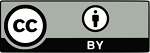

```
Chagué, Alix & Le Fourner, Victoria, "Structuration logique des Comptes-rendus des séances du Conseil des Prud'hommes de Paris pour l'industrie du textile (TIME US)", 2021 [Jupyter Notebook]
```



## 0\. Préambule 
Ce scénario de transformation a été mis en place dans le cadre du projet ANR Time Us. Il a été élaboré dans le cadre du stage de Victoria Le Fourner, conduit au sein de l'équipe ALMAnaCH du centre de recherche Inria Paris entre avril et juillet 2019. Il a été adapté sous la forme d'un Notebook Jupyter en juillet 2021 par Alix Chagué, ingénieure de recherche et développement au sein de l'équipe ALMAnaCH. 

### 0.1\. Scénario 1
Le scénario initial s'inscrivait dans un environnement adossé au logiciel Transkribus, dans lequel des images d'archives numérisées étaient transcrite automatique ou manuellement. 

1. Le programme [ExportFromTranskribus](https://gitlab.inria.fr/almanach/time-us/ExportFromTranskribus) s'appuyait sur la fonctionnalité d'export de Transkribus vers XML TEI et permettait de récupérer un fichier XML TEI unique pour un ensemble d'image.
2. Le script [StructurationMinute](https://gitlab.inria.fr/almanach/time-us/schema-tei/-/blob/master/E%20-%20Structuration%20automatique/E.1%20-%20StructurationMinute/StructurationMinute.py) permettait ensuite de modifier cet arbre XML de manière à retrouver la structure logique de chaque compte-rendu. 
  - pour voir un prototype du résultat : http://timeusage.paris.inria.fr/prudhommes-paris-19e/content/PHD-Paris-ensemble_manuscrit_2_audience_1.html
  - pour mieux comprendre la modélisation de la structure, voir :  *Le Fourner, Victoria. 2019. « Étude de la structuration automatique et de l'éditorialisation d'un corpus hétérogène, l'exemple des sources du conseil des prud'hommes pour le textile du XIXe siècle ». Mémoire de master. Technologies numériques appliquées à l'histoire. Paris : École nationale des chartes.*

###  0.2\. Scénario 2
Depuis la mise en place du scénario initial, les données du projet TIME US ont été basculées vers la [plateforme eScriptorium déployée par Inria](http://escriptorium.inria.fr). D'une part, eScriptorium ne permet pas (encore) d'exporter un fichier XML TEI, d'autre part, les évolutions de Transkribus ne garantissent plus la réussite de l'exécution du script ExportFromTranskribus. Il était donc nécessaire de réadapter la scénario de structuration automatique à l'état des données disponibles. 

En l'occurrence, on peut facilement exporter d'eScriptorium les transcriptions au format TXT, ce qui correspond à peu près à l'état de structuration du fichier à l'étape des données à la [ligne 373](https://gitlab.inria.fr/almanach/time-us/schema-tei/-/blob/master/E%20-%20Structuration%20automatique/E.1%20-%20StructurationMinute/StructurationMinute.py#L373) du programme StructurationMinute.

L'adaptation du scénario au nouvel environnement logiciel est aussi l'occasion d'optimiser la formulation des REGEX et la construction de l'arbre XML. 

###  0.3\. Structure

Chaque audience est structurée de la manière suivante : 

- `div @type=courtHearing`
  - `div @type=case`
    - `opener`
    - `div @type=identificationParties`
      - `span @type=part1` (× n)
      - `span @type=part2` (× n)
    - `div @type=pointDeFait`
    - `div @type=pointDeDroit`
    - `div @type=judgement`

###  0.4\. Données
On s'est appuyé sur les données des Conseils des Prud'hommes (CPH) de Paris de 1847-49, 1858 et 1878, disponibles ici : 

#### 1858:
- http://escriptorium.inria.fr/media/users/3/export_doc417_dataset_cph_paris_1858_fini_text_202107191516.txt

#### 1847-1849: 
- http://escriptorium.inria.fr/media/users/3/export_doc536_timeus_ad75_d1u10_379_prud_homme_text_202107201913.txt

#### 1878:
- http://escriptorium.inria.fr/media/users/3/export_doc538_timeus_ad75_d1u10_405_prud_homme_text_202107201917.txt


## 1\. Installation de l'environnement et des dépendances

In [1]:
import os
import bs4
from bs4 import BeautifulSoup, NavigableString

import re
from datetime import datetime

## 2\. Récupération des données sources


In [2]:
sources = ["https://escriptorium.inria.fr/media/users/3/export_doc417_dataset_cph_paris_1858_fini_text_202107191516.txt",  # tout 1858
           "https://escriptorium.inria.fr/media/users/3/export_doc536_timeus_ad75_d1u10_379_prud_homme_text_202107201913.txt", # tout 1847-49
           "https://escriptorium.inria.fr/media/users/3/export_doc538_timeus_ad75_d1u10_405_prud_homme_text_202107280912.txt", # pp 1-19 : janvier 1878
           "https://escriptorium.inria.fr/media/users/3/export_doc538_timeus_ad75_d1u10_405_prud_homme_text_202108250949.txt"]  # pp 375-462 : juin 1878 

titles = ["AD75 D1U10 386 Prud'hommes 1858",  # tout 1858
          "AD75 D1U10 379 Prud'hommes 1847-1849",  # tout 1847-49
          "AD75 D1U10 405 Prud'hommes 1878 - janvier",  # pp 1-19 : janvier 1878
          "AD75 D1U10 405 Prud'hommes 1878 - juin"]  # pp 375-462 : juin 1878 

### 2\.1 Téléchargement des fichiers sources avec WGET

Pour lancer cette commande localement, vous devez préalablement installer [`wget`](https://doc.ubuntu-fr.org/wget).

Pour chaque URL dirigeant vers un export TXT disponible, on télécharge le fichier et on calcule le nom du fichier une fois téléchargé, en le racourcissant si besoin.

In [3]:
source_bases = []
for source_url in sources:
    source_base = source_url.split("/")[-1]

    # on peut racourcir le nom du fichier si besoin ;
    #if len(source_base.split(".")[0]) > 20:
    #    source_rebase = source_base[:21] + "." + source_base.split(".")[-1] 
    #else:
    source_rebase = False
    
    !wget --no-check-certificate -N $source_url

    if source_rebase:
        !mv $source_base $source_rebase
        source_base = source_rebase
    
    source_bases.append(source_base)

--2021-10-25 16:36:50--  https://escriptorium.inria.fr/media/users/3/export_doc417_dataset_cph_paris_1858_fini_text_202107191516.txt
Resolving escriptorium.inria.fr (escriptorium.inria.fr)... 128.93.101.11
Connecting to escriptorium.inria.fr (escriptorium.inria.fr)|128.93.101.11|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 285069 (278K) [text/plain]
Saving to: ‘export_doc417_dataset_cph_paris_1858_fini_text_202107191516.txt’

export_doc417_datas 100%[===================>] 278.39K   686KB/s    in 0.4s    

2021-10-25 16:36:52 (686 KB/s) - ‘export_doc417_dataset_cph_paris_1858_fini_text_202107191516.txt’ saved [285069/285069]

--2021-10-25 16:36:52--  https://escriptorium.inria.fr/media/users/3/export_doc536_timeus_ad75_d1u10_379_prud_homme_text_202107201913.txt
Resolving escriptorium.inria.fr (escriptorium.inria.fr)... 128.93.101.11
Connecting to escriptorium.inria.fr (escriptorium.inria.fr)|128.93.101.11|:4

### 2\.2 Récupération du schéma RNG

Pour la validation des fichiers XML TEI générés (non géré dans ce notebook).

In [4]:
#schema_url = "https://gitlab.inria.fr/almanach/time-us/schema-tei/-/raw/master/D%20-%20Sch%C3%A9ma%20de%20validation/D.2%20-%20ODD/D.2.1%20-%20ODDmanuscrit/ODDmanuscrit.rng"
#base_url_schema = schema_url.split("/")[-1]

#!wget -N $schema_url

## 3\. Fonctions

L'ensemble des traitements effectués sur le texte peut être décomposé en 3 grandes étapes : 
- la construction de l'en-tête avec métadonnées
- la construction de la structure logique spécifique aux comptes-rendus des CPH et aux informations qui intéressent le projet ANR TIME US, sur la base de motifs textuels récurrents (expressions régulières)
- le nettoyage et l'ajout d'une couche d'annotation des dates d'audiences

Une fonction principale (`main()`) gère l'application de ces trois ensembles de modifications dans l'ordre souhaité. 

### 3\.1 Fonctions TeiHeader

On construit un gabarit contenant un body vide, qui sera rempli ensuite, et une en-tête avec les métadonnées propres au projet TIME US et au corpus des CPH de Paris. 

In [5]:
# structure du header
def build_tei_header(tei_title):
 return "".join(["<teiHeader>","<fileDesc>","<titleStmt>",
                      f"<title>{tei_title} - Transcription</title>",
                      "<editor>Alix Chagué</editor>",
                      "<respStmt>",
                      "<name>Alix Chagué</name><resp>Gestion des données, encodage de la structure logique</resp>",
                      "</respStmt>",
                      "<respStmt>",
                      "<name>Victoria Le Fourner</name><resp>Encodage de la structure des documents</resp>",
                      "</respStmt>",
                      "<respStmt>",
                      "<name>Kevin Champougny</name><resp>Correction de la transcription et prise de vues</resp>",
                      "</respStmt>","</titleStmt>",
                      "<publicationStmt>",
                      "<p>Time Us (2017-2020) : http://timeusage.paris.inria.fr/mediawiki/index.php/Accueil</p>",
                      "</publicationStmt>","<sourceDesc>","<p>No description</p>",
                      "</sourceDesc>", "</fileDesc>", "<encodingDesc>", "<projectDesc>", 
                      "<p>TIME US est un projet ANR dont le but est de reconstituer les rémunérations et les budgets temps des travailleur⋅ses du textile dans quatre villes industrielles française (Lille, Paris, Lyon, Marseille) dans une perspective européenne et de longue durée. Il réunit une équipe pluridisciplinaire d'historiens des techniques, de l'économie et du travail, des spécialistes du traitement automatique des langues et des sociologues spécialistes des budgets familiaux. Il vise à donner des clés pour comprendre le gender gap en analysant les mutations du travail et la répartition du temps et des tâches au sein des ménages pendant la première industrialisation. Pour ce faire, le projet met en place une action de transcription et d'annotation de documents d'archives datés de la fin du XVIIe au début du XXe siècle.</p>",
                      "</projectDesc>", "<editorialDecl>", 
                      "<p>Les transcriptions et leur annotations sont réalisées à l'aide de la plate-forme Transkribus.</p>",
                      "<p>Les transcriptions ont été transférées importées dans eScriptorium (escriptorium.inria.fr) et la validité de leur segmentation controlée manuellement.</p>",
                      "</editorialDecl>", "</encodingDesc>", "<revisionDesc>",
                      '<change type="Created">2018-12-19T23:03:09.528+01:00</change>',
                      '<change type="LastChange">2019-01-27T15:58:22.906+01:00</change>',
                      '<change type="toeScriptorium">2021-01</change>',
                      f'<change type="ToTEI">{str(datetime.now()).replace(" ", "T") + "+2:00"}</change>',
                      "</revisionDesc>", "</teiHeader>"])
    


def make_tei_container(title):
    container = """<TEI xmlns="http://www.tei-c.org/ns/1.0"></TEI>"""
    parsed_container = BeautifulSoup(container, "xml")
    parsed_tei_header = BeautifulSoup(build_tei_header(title), "xml").extract()
    parsed_container.TEI.append(parsed_tei_header)
    parsed_container.TEI.append(parsed_container.new_tag("text_blob"))
    return parsed_container

### 3\.2 Fonctions structure

La construction de la structure logique s'appuie sur des indices textuels récurrents tels que "Audience du" ou "Entre... d'une part ;" ou "... d'autre part ;" ou encore "Point de fait", "Point de droit", etc. L'utilisation d'expressions régulières permet de gagner en souplesse face aux variations dans la redaction et dans la transcription. 

In [6]:
def add_courthearing_clues(text):
    """Ajoute des div pour repérer le début de chaque nouvelle audience"""
    #PATTERN_DIV_COURTHEARING =re.compile(r"((?=(Audience)).*?((?= Audience|$)))") 
    # <- impossible de faire marcher cette regex dans le script, pourtant correcte
    text = text.replace("Audience", '</div><div type="courtHearing">Audience')
    return text


def add_case_clues(text):
    """Ajoute des div pour repérer le début de chaque nouvelle affaire"""
    # Target: Du jour ... / Du dit jour ... / Dudit jour ...
    text = re.sub(r"(Du ?(?:dit)? {0,}jour? ?v?.+?)(dessus|[eE]ntre)?", 
                  r'</div><div type="case">\1\2', text)
    # Target: Audience Du Lundi/Mardi/Mercredi/Jeudi/Vendredi
    # Noter que cibler seulement Vendredi serait suffisant
    text = re.sub(r"(Audience\s{0,})(\s{0,}[dD]u\s{0,}\s{0,}[A-z]+di )(.+)",
                  r'\1</div><div type="case">\2\3', text)
    return text


def remove_extra_divs(text):
    """Retire les div fermantes qui n'ont pas de div ouvrante correspondant"""
    if text.startswith("</div>"):
        text = text[6:]
    text = text.replace('Audience</div><div type="case">', 'Audience<div type="case">')
    return text


def force_clean_manusrit_div(text):
    text = re.sub(r"""^[\w\s\n]+</div><div type="courtHearing">""",
                  r"""<div type="courtHearing">""", text)
    return text


def build_tree(text):
    """Crée un arbre XML à partir d'une chaîne de caractères"""
    text = '<body><div type="manuscrit">ph</div></body>'.replace("ph", text)
    tree = BeautifulSoup(text, "xml")
    return tree


def add_n_counters_to_div(tree, type):
    """Ajoute des attributs "n" avec valeur incrémentée dans les div ciblées"""
    i = 0
    for tag in tree.find_all("div", type=type):
        tag.attrs["n"] = i
        i += 1
    return tree


def finely_structure_cases(tree):
    """Afine la structure des affaires en repérant les différents points"""
    for tag in tree.find_all("div", type="case"):
        tag_text = " ".join([seg for seg in tag.get_text().split("\n")])
        tag_text = re.sub(r" {2,}", " ", tag_text)

        # Ajout des opener et des div pour les identifications des parties
        text = re.sub(r"([Dd]u [A-z]+di)(.+)(Si[eèé]geaient ?:)(.+)(Entre )", 
                    r'<opener>\1\2\3\4</opener><div type="identificationParties">\5</div>', 
                    tag_text)
        text = re.sub(r"([dD]u ?(?:dit)? jour? v?)(.+?)([eE]ntre .+)", 
                    r'<opener>\1\2</opener><div type="identificationParties">\3</div>', 
                    tag_text)
        if not text.startswith("<opener>"):
            if re.search(r"Entre", text):
                text = "".join(["<opener>", text.replace('Entre ', '</opener><div type="identificationParties">Entre '), "</div>"])
            else:
                text = "".join(['<div type="undefined">', text, '</div>'])

        # Ajout des div pour les Points de fait
        text = re.sub(r"([pP]oint [Dd]e [Ff]ait.+)", 
                    r'</div><div type="pointDeFait">\1', 
                    text)
        # Ajout des div pour les Points de droit
        text = re.sub(r"([pP]oi?nt [Dd]e [Dd]r?oit.+)", 
                    r'</div><div type="pointDeDroit">\1', 
                    text)
        # Ajout des div pour les Jugements
        text = re.sub(r"([Aa]près avoir entendu|Ainsi jugé)(.+)", 
                    r'</div><div type="judgement">\1\2', 
                    text)
        # On s'assure que toutes les div et les p sont fermées
        if not text.endswith("</div>"):
            text = text + "</div>"
        # On réintègre tout cela dans l'arbre XML
        tag.contents = []
        new_content = BeautifulSoup(f"<blob>{text}</blob>", "xml").extract()
        for subtag in new_content.find_all(["div", "opener"]):
            tag.append(subtag)
    return tree


def identification_parties_et_date_audience(tree):
    """Afine la structure de l'identification des parties en repérant les différentes parties"""
    for tag in tree.find_all("div", type="identificationParties"):
        text = tag.get_text()
    
        # Il y a parfois plusieurs parties "d'une part"
        # notre approche change s'il n'y a qu'une partie d'une part ou plusieurs
        # et on essaie d'avoir un mécanisme de log quand on n'en trouve aucune
        # TODO : il y a beaucoup de répétitions, on pourrait utiliser des variables
        #        pour les motifs qui se répètent
        nmatches = len([x for x in re.finditer(r"([dD][’'4]?u(?:[un]e)? part)([\s;]+)", text)])
        if nmatches > 1:
            text = re.sub(r"(Entre)(.+?)([dD][’'4]?u(?:[un]e)? part)([\s;]+)", 
                        r'<span type="part1">\1\2\3\4</span>', text)
            for i in range(nmatches - 1):
                text = re.sub(r"([dD][’'4]?u(?:[un]e)? part[ ;]+</span>)(.+?)([dD][’'4]?u(?:ne)? part)([\s;]+)", 
                        r'\1<span type="part1">\2\3\4</span>', text)
        elif nmatches == 1:
            text = re.sub(r"(Entre)(.+)([dD][’'4]?u(?:[un]e)? part)([\s;]+)", 
                        r'<span type="part1">\1\2\3\4</span>', text)
        else:
            print("[" +str(nmatches) + "] Unable to find something like \"D'une part ;\" in:\n \"" + text + "\"\n")
    
        # Il y a parfois plusieurs parties "d'autre part"
        # notre approche change en fonction de s'il y a une partie d'autre part ou bien plusieurs
        # et on essaie d'avoir un mécanisme de log quand on n'en trouve aucune
        # TODO : on pourrait utiliser des variables pour les motifs qui se répètent
        nmatches = len([x for x in re.finditer(r"([dD][’'4]? ?autre )(part)?([\s,;]+)", text)])
        if nmatches > 1:
            text = re.sub(r"([dD][’'4] ?u(?:ne)? part[\s;]+</span>)(.+?)([dD][’'4]? ?autre )(part)?([\s,;]+)", 
                        r'\1<span type="part2">\2\3\4\5</span>', text)
            text = re.sub(r"([dD][’'4]? ?autre (?:part)?[\s;]+</span>)(.+?)([dD][’'4]? ?autre )(part)?([\s,;]+)", 
                        r'\1<span type="part2">\2\3\4\5</span>', text)
            text = re.sub(r"([dD][’'4]? ?autre (?:part)?[\s;]+</span>)([^<].+?)([dD][’'4]? ?autre )(part)?([\s,;]+)", 
                        r'\1<span type="part2">\2\3\4\5</span>', text)
        elif nmatches == 1:
            text = re.sub(r"([dD][’'4]?u(?:ne)? part[\s;]+</span>)(.+)([dD][’'4]? ?autre )(part)?([\s,;]+)", 
                        r'\1<span type="part2">\2\3\4\5</span>', text) 
        else:
            print("[" +str(nmatches) + "] Unable to find something like \"D'autre part ;\" in:\n \"" + text + "\"\n")
    
        # On réintègre tout ça dans l'arbre XML, de manière plus ou moins élégante...
        tag.clear()
        new_content = BeautifulSoup(f"<rs>{text}</rs>", "xml").extract()
        tag.append(new_content)
    return tree

### 3\.3 Fonction nettoyage et annotation

Pour s'assurer que le fichier qui sera enregistré est valide et conforme aux guidelines de la TEI, on ajoute les éléments manquants comme les `<p>` dans les éléments `<div>`. 

On peut également ajouter des éléments `<date>` autour d'un certain nombre de dates. Il est difficile de les cibler toutes dans la mesure où elles sont exprimées entièrement en toute lettres et il existe de nombreuses irrégularités dans le texte.

In [7]:
def clean_up(xml_tree):
    """Mostly add p elements in div where it's missing"""
    types = ["courtHearing", "identificationParties", 
           "pointDeFait", "pointDeDroit", "judgement",
           "undefined"]  #"manuscrit",
    for typ in types:
        for div in xml_tree.find_all("div", type=typ):
            new_p = xml_tree.new_tag("p")
            for c in div.contents:
                new_p.append(c.extract())
            div.append(new_p)
    return xml_tree

In [8]:
def build_date_regex():
    """Fonction séparée pour lisibilité"""
    # on va chercher les jours
    PAT_DAY = "|".join(["[Ll]undi", "[Mm]ardi", "[Mm]ercredi", "[Jj]eudi", "[Vv]endredi", "[Ss]amedi", "[Dd]imanche"])
    # il reste des scories dans la transcription qu'on gère comme des exceptions pour éviter de prendre trop de mots
    DATE_EXCP =  "|".join(["seijiliet","Viugeaient","Monsieure","conant","Courant","en demn se touer","par saite","\. légitime","\. Cité"])
    # Motif Regex des dates:
    pat_date = re.compile("".join(["([Dd]u )(",PAT_DAY, ")(.+?)( )([Ss]i?[éeè]g[aient]+|", DATE_EXCP, ")"]))
    # mémo captures : $1="du ", $2="vendredi", $3=" Dix neuf Janvier mil huit Cent quarante huit", $4=" ", $5="Siégeaient"
    return pat_date

def find_dates(xml_tree):
    """find dates and add <date> tags"""
    # On essaie de mettre des tags "date" seulement quand on est sûr que c'est une date
    # donc on a va manquer des éléments.
    date_regex = build_date_regex()
    # On récupère des bouts de texte dans lesquels on va chercher les dates
    scope = []
    for elem in xml_tree.body.find_all(["p", "span", "opener"]):
        for content in elem.contents:
            if content.name:
                if content.name == "rs" or content.name == "span":
                    for cont in content.contents:
                        if cont.name == "span":
                            scope.append(cont)
                        else:
                            scope.append(content)
                #else:
                #    print(content.name)
            else:
                scope.append(elem)
    # à ce moment-là, on n'a que des objets de type bs4.element.NavigableString dans scope
    #for elem in scope:
    #    if not isinstance(elem, bs4.element.NavigableString):
    #        print(type(elem))

    # on cherche les dates et on insère les dates
    for elem in scope:
        if elem.string:
            elem.string.replace_with(re.sub(date_regex, r"\1<date>\2\3</date>\4\5", elem.string, 0))
        #else:  # on a du mal à atteindre les string dans les elemn rs
        #    print(elem.name)
    return xml_tree


def fix_date_tags(tree_as_text):
    return tree_as_text.replace("&lt;date&gt;", "<date>").replace("&lt;/date&gt;", "</date>")

### 3\.4 Fonction principale

La fonction principale applique l'ensemble des transformations expliquées plus haut, en procédant pas à pas pour faciliter la lisibilité de l'enchaînement des transformations. A la fin, un fichier `.tei.xml` est créé.

In [9]:
def main(source, target, title, show_output=False):
    # On ouvre le fichier source
    with open(source, "r", encoding="utf8") as fh:
        source_as_text = fh.read()
    # suppression des césures et régularisation des espaces
    pattern_cesure = re.compile(r"[¬]+[ \n]+")
    source_as_text = " ".join(re.sub(pattern_cesure, "", source_as_text).split("\n"))
    source_as_text = re.sub(r" {2,}", r" ", source_as_text)

    # ajout d'indices de structure
    source_w_clues = add_courthearing_clues(source_as_text)
    source_w_clues = add_case_clues(source_w_clues)

    # nettoyage avant de parser le XML
    clean_text = force_clean_manusrit_div(remove_extra_divs(source_w_clues))

    # parsing et ajout d'éléments de structuration logique
    tree = build_tree(clean_text)
    tree = add_n_counters_to_div(tree, type="courtHearing")
    tree = add_n_counters_to_div(tree, type="case")
    tree = finely_structure_cases(tree)
    tree = identification_parties_et_date_audience(tree)

    # on remballe tout
    complete_tree = make_tei_container(title)
    complete_tree.text_blob.append(tree.extract())
    complete_tree = clean_up(complete_tree)
    complete_tree = find_dates(complete_tree)
    complete_tree.text_blob.name = "text"

    # enregistrement du fichier
    with open(target, "w", encoding="utf8") as fh:
        fh.write(fix_date_tags(complete_tree.prettify()))
  
    if show_output:
        print(fix_date_tags(complete_tree.prettify()))

## 4\. Execution

Après avoir calculé le nom du fichier de sortie, on exécute la fonction `main()` pour créer un fichier XML structuré !

In [10]:
for source, title in zip(source_bases, titles):
    # construction du nom du fichier cible
    ext = f".{source.split('.')[-1]}"
    target = source.replace(ext, ".tei.xml")
    target = re.sub(r"_{2,}", "_", target)

    # vérification du nom du fichier cible 
    print("# # # # # # # # #", target, "# # # # # # # # #\n")

    # Ajouter "show_output=True" pour afficher l'arbre XML
    main(source=source_base, target=target, title=title)#, show_output=True)

# # # # # # # # # export_doc417_dataset_cph_paris_1858_fini_text_202107191516.tei.xml # # # # # # # # #

[0] Unable to find something like "D'autre part ;" in:
 "<span type="part1">Entre Monsieur Bréchot, ouvrier Galochier, demeurant à Paris, rue de Meaux, numéro trente sept, passage de la Brie ; Demandeur ; Comparant ; D'une part ; </span>Et Monsieur Vermérot, fabricant de Galoches, demeurant et domicilié à Paris deux mots rayés nuls Lecucq — "

[0] Unable to find something like "D'autre part ;" in:
 "<span type="part1">Entre Madame veuve Bernard, ouvrière demeurant à Joinville le Pont, près Paris, rue du canal, numéro onze ; Demanderesse ; Comparant ; D'une part ; </span><span type="part1">Et Monsieur Bardin, fabricant plumassier, demeurant et domicilié à Joinville le Pont, rue des Réservoirs ; Défendeur ; Comparant ; D'une part ; </span>"

[0] Unable to find something like "D'autre part ;" in:
 "<span type="part1">Entre Monsieur Levonte, anvner lapeemntier, demeurant à Boles, au ron

## 5\. Aperçu du contenu des fichiers

Cette section permet de suivre le détail des transformations à travers l'exemple d'un fichier dont on affiche l'état à différentes étapes du processus. 

### 5.1 URL du fichier TXT sur eScriptorium

In [11]:
print(sources[-1])

https://escriptorium.inria.fr/media/users/3/export_doc538_timeus_ad75_d1u10_405_prud_homme_text_202108250949.txt


### 5\.2 Contenu du fichier TXT exporté de l'application eScriptorium

In [12]:
with open(source_bases[-1], "r", encoding="utf8") as fh:
    txt_content = fh.read()

print(txt_content)

Audience
du
Jeudi six Juin mil huit cent soixante dix huit.
Siégeaient : Messieurs
Pinaud, Chevalier de la Légion d'honneur, vice
Président du conseil de Prud'homme du Département
de la Seine pour l'Industrie des tissus, Lerroy,
Larcher, Platiau, Broutin, Godfrin
et Meslien, Prud'hommes assistés de Monsieur
Lecucq, secrétaire dudit conseil
Entre Monsieur et Madame Lablanche,
le sieur Lablanche tant en son nom personnel que pour
assister et autoriser la dame son épouse ouvrière passementière,
demeurant ensemble, les dits époux, à Paris, rue Besfroid,
numéro dix ; Demandeur ; Comparant ; D'une part ; et
Monsieur Nisson, fabricant passementier, demeurant et
domicilié à Paris, rue Rambuteau, numéro trente huit ;
Défendeur ; Défaillant ; D'autre part ; Point de fait = 
Par lettres du secrétaire du conseil de Prud'hommes du Département
de la Seine pour l'industrie des tissus en dates des Lundi vingt
et Mardi vingt un Mai mil huit cent soixante dix huit les époux
Lablanche firent citer nisson

### 5\.3 Contenu textuel après nettoyage de base et ajout des indices de structure logique

In [13]:
pattern_cesure = re.compile(r"[¬]+[ \n]+")
source_as_text = " ".join(re.sub(pattern_cesure, "", txt_content).split("\n"))
source_as_text = re.sub(r" {2,}", r" ", source_as_text)

source_w_clues = add_courthearing_clues(source_as_text)
source_w_clues = add_case_clues(source_w_clues)

clean_text = force_clean_manusrit_div(remove_extra_divs(source_w_clues))

print(clean_text)

<div type="courtHearing">Audience </div><div type="case">du Jeudi six Juin mil huit cent soixante dix huit. Siégeaient : Messieurs Pinaud, Chevalier de la Légion d'honneur, vice Président du conseil de Prud'homme du Département de la Seine pour l'Industrie des tissus, Lerroy, Larcher, Platiau, Broutin, Godfrin et Meslien, Prud'hommes assistés de Monsieur Lecucq, secrétaire dudit conseil Entre Monsieur et Madame Lablanche, le sieur Lablanche tant en son nom personnel que pour assister et autoriser la dame son épouse ouvrière passementière, demeurant ensemble, les dits époux, à Paris, rue Besfroid, numéro dix ; Demandeur ; Comparant ; D'une part ; et Monsieur Nisson, fabricant passementier, demeurant et domicilié à Paris, rue Rambuteau, numéro trente huit ; Défendeur ; Défaillant ; D'autre part ; Point de fait = Par lettres du secrétaire du conseil de Prud'hommes du Département de la Seine pour l'industrie des tissus en dates des Lundi vingt et Mardi vingt un Mai mil huit cent soixante d

### 5\.4 Contenu du fichier XML après ajout des éléments de structure

In [14]:
tree = build_tree(clean_text)
tree = add_n_counters_to_div(tree, type="courtHearing")
tree = add_n_counters_to_div(tree, type="case")
tree = finely_structure_cases(tree)
tree = identification_parties_et_date_audience(tree)

print(tree.prettify())

[0] Unable to find something like "D'autre part ;" in:
 "<span type="part1">Entre Monsieur Bréchot, ouvrier Galochier, demeurant à Paris, rue de Meaux, numéro trente sept, passage de la Brie ; Demandeur ; Comparant ; D'une part ; </span>Et Monsieur Vermérot, fabricant de Galoches, demeurant et domicilié à Paris deux mots rayés nuls Lecucq — "

[0] Unable to find something like "D'autre part ;" in:
 "<span type="part1">Entre Madame veuve Bernard, ouvrière demeurant à Joinville le Pont, près Paris, rue du canal, numéro onze ; Demanderesse ; Comparant ; D'une part ; </span><span type="part1">Et Monsieur Bardin, fabricant plumassier, demeurant et domicilié à Joinville le Pont, rue des Réservoirs ; Défendeur ; Comparant ; D'une part ; </span>"

[0] Unable to find something like "D'autre part ;" in:
 "<span type="part1">Entre Monsieur Levonte, anvner lapeemntier, demeurant à Boles, au rondipement de Clermont leisa j Demandur, Comperant ; D'une part ; </span><span type="part1">Et Monpeur Curt

### 5\.5 Contenu du fichier XML prêt à être enregistré

In [15]:
complete_tree = make_tei_container(titles[-1])
complete_tree.text_blob.append(tree.extract())
complete_tree = clean_up(complete_tree)
complete_tree = find_dates(complete_tree)
complete_tree.text_blob.name = "text"
ready_text = fix_date_tags(complete_tree.prettify())

print(ready_text)

<?xml version="1.0" encoding="utf-8"?>
<TEI xmlns="http://www.tei-c.org/ns/1.0">
 <teiHeader>
  <fileDesc>
   <titleStmt>
    <title>
     AD75 D1U10 405 Prud'hommes 1878 - juin - Transcription
    </title>
    <editor>
     Alix Chagué
    </editor>
    <respStmt>
     <name>
      Alix Chagué
     </name>
     <resp>
      Gestion des données, encodage de la structure logique
     </resp>
    </respStmt>
    <respStmt>
     <name>
      Victoria Le Fourner
     </name>
     <resp>
      Encodage de la structure des documents
     </resp>
    </respStmt>
    <respStmt>
     <name>
      Kevin Champougny
     </name>
     <resp>
      Correction de la transcription et prise de vues
     </resp>
    </respStmt>
   </titleStmt>
   <publicationStmt>
    <p>
     Time Us (2017-2020) : http://timeusage.paris.inria.fr/mediawiki/index.php/Accueil
    </p>
   </publicationStmt>
   <sourceDesc>
    <p>
     No description
    </p>
   </sourceDesc>
  </fileDesc>
  <encodingDesc>
   <projectDesc>